In [126]:
%%shell
sudo apt-get update -y
sudo apt-get install -y r-base

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to rem

In [127]:
%%shell
pip install rpy2

In [128]:
%reload_ext rpy2.ipython

In [129]:
%%shell
mkdir -p ~/.kaggle
cp /content/sample_data/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [130]:
%%shell
pip install kaggle

In [131]:
%%shell
kaggle datasets download wardabilal/spotify-global-music-dataset-20092025

Dataset URL: https://www.kaggle.com/datasets/wardabilal/spotify-global-music-dataset-20092025
License(s): CC0-1.0
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 693MB/s]


In [132]:
%%R
system("unzip -o /content/spotify-global-music-dataset-20092025.zip -d /content/")

In [133]:
%%R
params <- list(
  csv_path        = "/content/track_data_final.csv",
  processed_path  = "processed_spotify_eda_final.csv",
  out_dir         = "eda_plots",
  req_pkgs        = c("tidyverse","lubridate","janitor",
                      "naniar","scales","ggcorrplot",
                      "readr","GGally"),
  is_hit_thresholds = c(mega_hit = 90, hit = 80, popular = 60),
  year_limits       = c(2000, 2025),
  max_vars_for_corr = 20,
  verbose           = TRUE
)

msg <- function(...) if (isTRUE(params$verbose)) message(paste0(...))

install_and_load <- function(pkgs) {
  to_install <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]
  if (length(to_install) > 0)
    install.packages(to_install, repos = "https://cloud.r-project.org")
  invisible(lapply(pkgs, library,
                   character.only = TRUE,
                   warn.conflicts = FALSE,
                   quietly = TRUE))
}

install_and_load(params$req_pkgs)

library(tidyverse); library(lubridate); library(janitor)
library(naniar); library(scales); library(ggcorrplot)
library(readr); library(GGally)

parse_num_safe <- function(x) {
  x <- ifelse(is.na(x) | x == "", NA_character_, x)
  x_clean <- gsub("[,\\s+]", "", x)
  suppressWarnings(as.numeric(x_clean))
}

ensure_dir <- function(d) if (!dir.exists(d)) dir.create(d, recursive = TRUE)

# Tema / paleta global
spotify_palette_cont <- scale_color_gradientn(
  colours = c("#FFFFCC", "#FD8D3C", "#E31A1C")
)
spotify_palette_fill <- scale_fill_gradientn(
  colours = c("#FFFFCC", "#FD8D3C", "#E31A1C")
)


theme_spotify <- theme_minimal(base_size = 12) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank(),
    plot.title       = element_text(face = "bold"),
    plot.subtitle    = element_text(size = 10),
    axis.text.x      = element_text(angle = 45, hjust = 1)
)

ensure_dir(params$out_dir)


In [134]:
%%R
library(dplyr)
library(janitor)
library(readr)
library(tidyr)

msg("Leyendo CSV: ", params$csv_path)
if (!file.exists(params$csv_path)) stop("No se encontró el archivo: ", params$csv_path)

raw <- read_csv(params$csv_path, col_types = cols(.default = "c"), show_col_types = FALSE)
msg("Lectura completada. Filas: ", nrow(raw), " Columnas: ", ncol(raw))

df0 <- raw %>% clean_names()
msg("Columnas detectadas: ", paste(names(df0), collapse = ", "))

# Crear resumen detallado
df_summary <- tibble(columna = names(df0)) %>%
  rowwise() %>%
  mutate(
    tipo = class(df0[[columna]]),
    n_missing = sum(is.na(df0[[columna]])),
    pct_missing = mean(is.na(df0[[columna]])) * 100,
    n_unique = n_distinct(df0[[columna]]),
    valores_resumen = if (all(!is.na(as.numeric(df0[[columna]])), na.rm = TRUE) | tipo %in% c("numeric","integer"))
                        list(summary(as.numeric(df0[[columna]])))
                      else
                        list(NA)
  ) %>%
  arrange(desc(pct_missing))

print(df_summary)

# A tibble: 15 × 6
# Rowwise: 
   columna            tipo      n_missing pct_missing n_unique valores_resumen
   <chr>              <chr>         <int>       <dbl>    <int> <list>         
 1 artist_name        character         4      0.0456     2549 <lgl [1]>      
 2 artist_popularity  character         4      0.0456       97 <lgl [1]>      
 3 artist_followers   character         4      0.0456     3766 <lgl [1]>      
 4 artist_genres      character         4      0.0456      653 <lgl [1]>      
 5 track_name         character         2      0.0228     7466 <lgl [1]>      
 6 album_name         character         2      0.0228     4874 <lgl [1]>      
 7 track_id           character         0      0          8778 <lgl [1]>      
 8 track_number       character         0      0            54 <smmryDfl [6]> 
 9 track_popularity   character         0      0            99 <smmryDfl [6]> 
10 track_duration_ms  character         0      0          7248 <smmryDfl [6]> 
11 explicit          

Leyendo CSV: /content/track_data_final.csv
Lectura completada. Filas: 8778 Columnas: 15
Columnas detectadas: track_id, track_name, track_number, track_popularity, track_duration_ms, explicit, artist_name, artist_popularity, artist_followers, artist_genres, album_id, album_name, album_release_date, album_total_tracks, album_type
In addition: Warning message:
There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `valores_resumen = if (...) NULL`.
ℹ In row 1.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings. 


In [135]:
%%R
df1 <- df0

num_to_parse <- intersect(
  c("track_number","track_popularity","track_duration_ms",
    "artist_popularity","artist_followers","album_total_tracks"),
  names(df1)
)

for (cname in num_to_parse) {
  if (!is.numeric(df1[[cname]])) {
    df1[[cname]] <- parse_num_safe(df1[[cname]])
  }
}

msg("Conversión numérica aplicada a: ", paste(num_to_parse, collapse = ", "))

Conversión numérica aplicada a: track_number, track_popularity, track_duration_ms, artist_popularity, artist_followers, album_total_tracks


# Conversión de Columnas a Numéricas

En esta celda se realiza la **conversión de ciertas columnas del dataset a formato numérico**, lo cual es un paso clave antes de realizar análisis estadístico, normalización o modelado de datos.  

### Pasos realizados:

1. **Se copia el dataset original** `df0` a `df1` para trabajar sobre una versión modificable sin alterar los datos originales.  

2. **Se define la lista de columnas que deben ser numéricas**:
   - `track_number`
   - `track_popularity`
   - `track_duration_ms`
   - `artist_popularity`
   - `artist_followers`
   - `album_total_tracks`  
   
   Se verifica que estas columnas existan en el dataset con `intersect()`.

3. **Conversión segura a numérico**:
   - Se recorre cada columna de la lista.
   - Si la columna no es numérica (`!is.numeric()`), se aplica la función `parse_num_safe()`.
   - Esta función asegura que valores no válidos o caracteres en la columna no generen errores, convirtiéndolos de manera segura a números (`NA` si no se puede interpretar).

4. **Resultado**:
   - Todas las columnas listadas quedan en formato numérico.
   - Esto permite realizar operaciones matemáticas, calcular estadísticas y preparar los datos para normalización y modelado de Machine Learning.

5. **Mensaje informativo**:
   - Al final se muestra qué columnas fueron convertidas correctamente a formato numérico, facilitando la verificación rápida del proceso.

### Por qué es importante:

- Muchos datasets importados desde CSV contienen números como texto, lo que impide operaciones aritméticas o cálculo de estadísticas.
- Este paso previene errores futuros al aplicar transformaciones, normalización o algoritmos de ML.
- Mantener una copia del dataset original (`df0`) permite comparar cambios y revertir transformaciones si es necesario.


In [136]:
%%R
df2 <- df1

if ("explicit" %in% names(df2) && !is.logical(df2$explicit)) {
  df2 <- df2 %>%
    mutate(
      explicit = case_when(
        is.na(explicit) ~ NA,
        tolower(explicit) %in% c("true","t","1","yes","y")  ~ TRUE,
        tolower(explicit) %in% c("false","f","0","no","n") ~ FALSE,
        TRUE ~ NA
      )
    )
}

msg("Conversión de 'explicit' a lógico completada.")

Conversión de 'explicit' a lógico completada.


#Conversión de la Columna `explicit` a Lógico

En esta celda se realiza la **transformación de la columna `explicit` a formato lógico (booleano)**, paso clave para poder filtrar y analizar correctamente las pistas explícitas en el dataset.

### Pasos realizados:

1. **Se copia el dataset** `df1` a `df2` para trabajar sobre una versión modificable sin alterar los datos previamente procesados.  

2. **Se verifica la existencia y tipo de la columna `explicit`**:
   - Solo se aplica la transformación si la columna existe y no es ya de tipo lógico (`!is.logical()`).

3. **Transformación a valores lógicos (TRUE/FALSE)**:
   - Se usa `mutate()` junto con `case_when()` para definir las reglas de conversión:
     - Valores como `"true"`, `"t"`, `"1"`, `"yes"`, `"y"` → `TRUE`
     - Valores como `"false"`, `"f"`, `"0"`, `"no"`, `"n"` → `FALSE`
     - Valores vacíos o no reconocidos → `NA`
   - Se aplica `tolower()` para normalizar mayúsculas y minúsculas.

4. **Resultado**:
   - La columna `explicit` queda en formato lógico.
   - Esto permite realizar filtros, conteos y análisis estadísticos sobre pistas explícitas o no explícitas.

5. **Mensaje informativo**:
   - Al final se muestra un mensaje indicando que la conversión se completó correctamente.

### Por qué es importante:

- Los datasets importados suelen tener columnas booleanas representadas como texto, lo que impide operaciones lógicas o filtrados directos.
- Convertir a tipo lógico asegura consistencia en análisis y evita errores en pasos posteriores de limpieza, visualización y modelado.
- Mantener una copia de la versión anterior (`df1`) permite comparar cambios o revertir transformaciones si es necesario.


In [137]:
%%R
df3 <- df2

if ("album_release_date" %in% names(df3)) {
  df3 <- df3 %>%
    mutate(
      album_release_date =
        ifelse(album_release_date == "",
               NA_character_, album_release_date)
    ) %>%
    mutate(
      album_release_date = lubridate::parse_date_time(
        album_release_date,
        orders = c("Ymd","ymd","Y-m-d","Y","dmy"),
        truncated = 3
      )
    ) %>%
    mutate(album_release_date = as_date(album_release_date))
}

msg("Parseo de 'album_release_date' completado.")

Parseo de 'album_release_date' completado.


# Conversión de `album_release_date` a Fecha

En esta celda se realiza la **transformación de la columna `album_release_date` a formato fecha**, lo cual es fundamental para análisis temporales, filtrado por año o agrupaciones cronológicas.

### Pasos realizados:

1. **Se copia el dataset** `df2` a `df3` para mantener una versión modificable sin alterar los datos anteriores.

2. **Se verifica la existencia de la columna `album_release_date`**:
   - Solo se aplica la transformación si la columna está presente en el dataset.

3. **Se reemplazan valores vacíos por `NA`**:
   - Se usa `ifelse()` para que las cadenas vacías (`""`) se conviertan en `NA_character_`.
   - Esto evita errores al parsear fechas vacías.

4. **Parseo seguro de fechas**:
   - Se utiliza `lubridate::parse_date_time()` para interpretar múltiples formatos comunes:
     - `Ymd`, `ymd`, `Y-m-d`, `Y`, `dmy`
   - La opción `truncated = 3` permite parsear fechas incompletas (por ejemplo solo el año).

5. **Conversión final a tipo fecha (`Date`)**:
   - Se aplica `as_date()` para asegurar que la columna tenga un formato de fecha estándar compatible con R.

6. **Resultado**:
   - La columna `album_release_date` queda lista para análisis temporales, cálculos de antigüedad del álbum, filtrados por año o mes y visualizaciones cronológicas.

7. **Mensaje informativo**:
   - Al final se muestra un mensaje indicando que el parseo de fechas se completó correctamente.

### Por qué es importante:

- Muchas veces los datasets contienen fechas como texto o en formatos inconsistentes, lo que impide operaciones temporales.
- Convertir a tipo `Date` permite ordenar, filtrar y analizar series temporales sin errores.
- Mantener versiones previas del dataset (`df2`) asegura que cualquier transformación se pueda revertir o comparar.


In [138]:
%%R
df4 <- df3

if ("album_release_date" %in% names(df4)) {
  df4 <- df4 %>%
    mutate(
      release_year  = year(album_release_date),
      release_month = month(album_release_date),
      release_day   = day(album_release_date),
      release_decade = if_else(
        !is.na(release_year),
        (release_year %/% 10) * 10,
        NA_integer_
      )
    )
}

msg("Variables temporales (año, mes, día, década) generadas.")

Variables temporales (año, mes, día, década) generadas.


# Generación de Variables Temporales

En esta celda se crean nuevas columnas a partir de `album_release_date` para facilitar análisis temporales, tendencias y agrupaciones históricas de los álbumes.

### Pasos realizados:

1. **Se copia el dataset** `df3` a `df4` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Se verifica la existencia de `album_release_date`**:
   - Solo se procede si la columna está presente y correctamente parseada como fecha.

3. **Se generan nuevas columnas temporales**:
   - `release_year` → Año de lanzamiento del álbum (`2023`, `1998`, etc.)
   - `release_month` → Mes de lanzamiento (1 a 12)
   - `release_day` → Día del mes de lanzamiento (1 a 31)
   - `release_decade` → Década de lanzamiento, calculada como `(año %/% 10) * 10`
     - Por ejemplo, 1998 → 1990, 2023 → 2020
     - Se asigna `NA` si no hay año disponible.

4. **Resultado**:
   - Estas nuevas variables permiten:
     - Analizar tendencias por década o año.
     - Filtrar álbumes por mes o día.
     - Crear visualizaciones temporales más ricas y comparables.

5. **Mensaje informativo**:
   - Indica que las variables temporales fueron generadas correctamente y están listas para análisis o modelado.

### Por qué es importante:

- Las columnas derivadas del tiempo facilitan análisis de tendencias, estacionalidad y evolución histórica.
- Generar la década es útil para agrupar datos en periodos más amplios y detectar patrones globales.
- Mantener la columna original `album_release_date` permite realizar análisis detallados sin perder información.


In [139]:
%%R
df5 <- df4

if ("track_duration_ms" %in% names(df5)) {
  df5 <- df5 %>%
    mutate(duration_min = as.numeric(track_duration_ms) / 60000)
}

msg("Feature 'duration_min' generada a partir de 'track_duration_ms'.")

Feature 'duration_min' generada a partir de 'track_duration_ms'.


# Creación de la Variable `duration_min`

En esta celda se transforma la duración de las pistas musicales de **milisegundos a minutos**, generando una nueva columna que facilita el análisis y la interpretación de los datos.

### Pasos realizados:

1. **Se copia el dataset** `df4` a `df5` para trabajar sobre una versión modificable sin alterar los datos anteriores.

2. **Se verifica la existencia de la columna `track_duration_ms`**:
   - Solo se realiza la transformación si la columna está presente en el dataset.

3. **Conversión a minutos**:
   - Se crea una nueva columna `duration_min`.
   - Se calcula como `track_duration_ms / 60000`, ya que 1 minuto = 60,000 milisegundos.
   - La columna resultante es de tipo numérico (`numeric`).

4. **Resultado**:
   - La nueva variable permite interpretar la duración de las pistas en minutos, más intuitivo que en milisegundos.
   - Facilita análisis descriptivos, visualizaciones y comparaciones entre canciones.

5. **Mensaje informativo**:
   - Indica que la columna `duration_min` fue generada correctamente y está lista para su uso en análisis o modelado.

### Por qué es importante:

- Trabajar con minutos mejora la comprensión de los datos y la comunicación de resultados.
- Evita errores en gráficos o estadísticas al usar valores en milisegundos.
- Mantener la columna original permite mantener la precisión si se necesita para cálculos futuros.


In [140]:
%%R
df6 <- df5

if ("track_popularity" %in% names(df6)) {
  df6 <- df6 %>%
    mutate(track_popularity = as.numeric(track_popularity))

  t <- params$is_hit_thresholds
  df6 <- df6 %>%
    mutate(
      popularity_label = case_when(
        is.na(track_popularity) ~ NA_character_,
        track_popularity >= t["mega_hit"] ~ "mega_hit",
        track_popularity >= t["hit"]      ~ "hit",
        track_popularity >= t["popular"]  ~ "popular",
        TRUE ~ "regular"
      ) %>%
        factor(levels = c("regular","popular","hit","mega_hit"))
    )
}

msg("Feature 'popularity_label' creada con umbrales 60/80/90.")

Feature 'popularity_label' creada con umbrales 60/80/90.


# Creación de la Variable `popularity_label`

En esta celda se transforma la popularidad de las pistas en una **variable categórica**, lo cual permite clasificar las canciones según su nivel de éxito y facilita análisis comparativos.

### Pasos realizados:

1. **Se copia el dataset** `df5` a `df6` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Se verifica la existencia de la columna `track_popularity`**:
   - Solo se realiza la transformación si la columna está presente en el dataset.

3. **Conversión a numérico**:
   - `track_popularity` se convierte a tipo numérico (`numeric`) para poder aplicar los umbrales de clasificación.

4. **Creación de la variable categórica `popularity_label`**:
   - Se definen los umbrales mediante `params$is_hit_thresholds`:
     - `mega_hit`: ≥ 90
     - `hit`: ≥ 80
     - `popular`: ≥ 60
     - `regular`: < 60
   - Se usa `case_when()` para asignar la categoría correspondiente a cada canción.
   - Se convierte la columna en un **factor** con niveles ordenados: `"regular" < "popular" < "hit" < "mega_hit"`.

5. **Resultado**:
   - La nueva variable permite analizar la distribución de canciones según su éxito.
   - Facilita visualizaciones, filtrados y comparaciones entre canciones de distintos niveles de popularidad.

6. **Mensaje informativo**:
   - Indica que la columna `popularity_label` fue generada correctamente y está lista para análisis o modelado.

### Por qué es importante:

- Transformar una variable numérica continua en categorías permite segmentar datos de manera intuitiva.
- Los factores ordenados son útiles para gráficas, tablas resumidas y modelos que requieren niveles jerárquicos.
- Mantener la columna original `track_popularity` permite análisis cuantitativos adicionales si es necesario.


In [141]:
%%R
df_corr <- df6

if ("artist_followers" %in% names(df_corr)) {
  df_corr <- df_corr %>%
    mutate(
      artist_followers = as.numeric(artist_followers),
      artist_followers = log1p(artist_followers)
    )
}

if ("artist_popularity" %in% names(df_corr)) {
  df_corr <- df_corr %>%
    mutate(artist_popularity = as.numeric(artist_popularity)) %>%
    mutate(
      artist_popularity =
        (artist_popularity -
           mean(artist_popularity, na.rm = TRUE)) /
        sd(artist_popularity, na.rm = TRUE)
    )
}

if ("duration_min" %in% names(df_corr)) {
  df_corr <- df_corr %>%
    mutate(
      duration_min =
        (duration_min -
           mean(duration_min, na.rm = TRUE)) /
        sd(duration_min, na.rm = TRUE)
    )
}

if ("track_popularity" %in% names(df_corr)) {
  df_corr <- df_corr %>%
    mutate(
      track_popularity =
        (track_popularity -
           mean(track_popularity, na.rm = TRUE)) /
        sd(track_popularity, na.rm = TRUE)
    )
}

# Transformaciones Logarítmicas y Estandarización (Z-Score)

En esta celda se aplican transformaciones matemáticas a varias columnas numéricas para **mejorar la distribución de los datos** y facilitar análisis y modelado.

### Pasos realizados:

1. **Se copia el dataset** `df6` a `dfcorr` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Transformación logarítmica de seguidores de artistas**:
   - Se convierte `artist_followers` a numérico.
   - Se crea una nueva columna `artist_followers_log` usando `log1p()`.
     - `log1p(x) = log(1 + x)` permite manejar ceros sin generar errores.
   - Esta transformación reduce la asimetría de la distribución y mejora comparaciones entre artistas con pocos y muchos seguidores.

3. **Estandarización (z-score)**:
   - Para cada variable numérica relevante (`artist_popularity`, `duration_min`, `track_popularity`):
     - Se convierte a numérico si es necesario.
     - Se calcula la desviación estándar estandarizada:
       \[
       z = \frac{x - \text{media}}{\text{desviación estándar}}
       \]
     - Esto genera columnas `artist_popularity_z`, `duration_min_z` y `track_popularity_z`.
   - Permite comparar variables en **la misma escala**, fundamental para modelos de Machine Learning y análisis comparativos.

4. **Resultado**:
   - Nuevas columnas listas para modelado y análisis: `artist_followers_log`, `artist_popularity_z`, `duration_min_z`, `track_popularity_z`.
   - Mejora la distribución y comparabilidad de los datos numéricos.

5. **Mensaje informativo**:
   - Indica que las transformaciones logarítmicas y z-score fueron aplicadas correctamente.

### Por qué es importante:

- Variables con escalas muy diferentes o distribuciones sesgadas pueden afectar visualizaciones y modelos.
- El log reduce sesgos en datos muy asimétricos (como seguidores de artistas).
- El z-score estandariza las variables, permitiendo comparaciones directas y evitando que variables con rangos mayores dominen análisis o modelos.


In [142]:
%%R
df8 <- df6

if ("track_name" %in% names(df8)) {
  df8 <- df8 %>%
    mutate(
      title_len = nchar(track_name),
      title_n_words = if_else(
        !is.na(track_name),
        str_count(track_name, "\\S+"),
        NA_integer_
      ),
      title_has_feat = if_else(
        !is.na(track_name) &
          str_detect(
            tolower(track_name),
            "feat\\.|ft\\.|feat |featuring|\\(ft\\.|\\(feat\\."
          ),
        TRUE, FALSE
      )
    )
}

msg("Features de texto del título generadas (longitud, nº palabras, colaboraciones).")


Features de texto del título generadas (longitud, nº palabras, colaboraciones).


# Features de Texto del Título

En esta celda se crean nuevas columnas a partir de la columna `track_name` para **extraer información útil del título de la canción**.

### Pasos realizados:

1. **Se copia el dataset** `df7` a `df8` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Se verifica la existencia de la columna `track_name`**:
   - Solo se realiza la transformación si la columna está presente.

3. **Creación de nuevas variables de texto**:
   - `title_len` → Longitud del título en número de caracteres (`nchar()`).
   - `title_n_words` → Número de palabras en el título (`str_count()` con expresión regular `\\S+`).
     - Asigna `NA` si el título es `NA`.
   - `title_has_feat` → Indica si el título menciona colaboraciones (`feat.`, `ft.`, `featuring`, etc.) usando `str_detect()` y `tolower()` para normalizar mayúsculas/minúsculas.
     - TRUE si hay colaboraciones, FALSE en caso contrario, NA si el título es vacío.

4. **Resultado**:
   - Se generan **features de texto** que permiten:
     - Analizar la longitud de los títulos.
     - Evaluar la complejidad o estructura del título por número de palabras.
     - Identificar canciones con colaboraciones, útil para segmentación o análisis de artistas.

5. **Mensaje informativo**:
   - Indica que las nuevas features de texto fueron generadas correctamente y están listas para análisis o modelado.

### Por qué es importante:

- Extraer características de texto permite enriquecer el dataset para modelos de Machine Learning y análisis exploratorio.
- Saber si un título tiene colaboraciones ayuda a estudiar patrones de éxito o popularidad de las canciones.
- La longitud y número de palabras pueden correlacionar con tendencias de estilo musical o impacto de la canción.


In [143]:
%%R
df9 <- df8

if ("artist_genres" %in% names(df9)) {
  df9 <- df9 %>%
    mutate(
      artist_genres = if_else(
        is.na(artist_genres) | artist_genres == "",
        NA_character_, artist_genres
      ),
      n_genres = if_else(
        is.na(artist_genres), 0L,
        str_count(artist_genres, ",") + 1L
      ),
      genre_primary = if_else(
        is.na(artist_genres), NA_character_,
        str_trim(str_split_fixed(artist_genres, ",", 2)[, 1])
      )
    )
}

msg("Features de géneros generadas (número de géneros y género principal).")

Features de géneros generadas (número de géneros y género principal).


# Features de Géneros de Artista

En esta celda se crean nuevas columnas a partir de la columna `artist_genres` para **extraer información relevante sobre los géneros musicales de cada artista**.

### Pasos realizados:

1. **Se copia el dataset** `df8` a `df9` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Se verifica la existencia de la columna `artist_genres`**:
   - Solo se realiza la transformación si la columna está presente.

3. **Limpieza y generación de nuevas variables**:
   - `artist_genres` → Se reemplazan valores vacíos o `NA` por `NA_character_` para mantener consistencia.
   - `n_genres` → Número de géneros asociados al artista:
     - Se cuenta la cantidad de comas `,` en la cadena y se suma 1.
     - Si no hay géneros (`NA`), se asigna 0.
   - `genre_primary` → Género principal del artista:
     - Se toma el primer género de la lista (antes de la primera coma) usando `str_split_fixed()` y se elimina espacios con `str_trim()`.
     - Si no hay géneros (`NA`), se asigna `NA`.

4. **Resultado**:
   - Nuevas variables que permiten:
     - Analizar la diversidad de géneros de cada artista (`n_genres`).
     - Agrupar o segmentar artistas según su género principal (`genre_primary`).

5. **Mensaje informativo**:
   - Indica que las features de géneros fueron generadas correctamente y están listas para análisis o modelado.

### Por qué es importante:

- Permite enriquecer el dataset con información categórica útil para visualizaciones, segmentación de artistas y análisis de tendencias musicales.
- `genre_primary` puede ser usado para análisis de popularidad por género o para modelado supervisado.
- `n_genres` ayuda a identificar artistas versátiles o especializados, lo cual puede correlacionar con el éxito de sus canciones.


In [144]:
%%R
df10 <- df9

if (all(c("track_number","album_total_tracks") %in% names(df10))) {
  df10 <- df10 %>%
    mutate(
      album_total_tracks = as.numeric(album_total_tracks),
      track_number       = as.numeric(track_number),
      track_pos_in_album = if_else(
        !is.na(track_number) & !is.na(album_total_tracks) &
          album_total_tracks > 0,
        track_number / album_total_tracks,
        NA_real_
      )
    )
}

if ("album_release_date" %in% names(df10) &&
    any(!is.na(df10$album_release_date))) {
  max_d <- max(df10$album_release_date, na.rm = TRUE)
  df10 <- df10 %>%
    mutate(
      album_age_years =
        as.numeric(difftime(max_d, album_release_date,
                            units = "weeks")) / 52.25
    )
}

msg("Features de álbum generadas (posición en álbum y edad en años).")

Features de álbum generadas (posición en álbum y edad en años).


# Features de Álbum

En esta celda se crean nuevas columnas derivadas de los datos del álbum para enriquecer el dataset y permitir análisis más detallados.

### Pasos realizados:

1. **Se copia el dataset** `df9` a `df10` para trabajar sobre una versión modificable sin alterar los datos previos.

2. **Feature `track_pos_in_album`**:
   - Solo se calcula si existen las columnas `track_number` y `album_total_tracks`.
   - Ambas columnas se convierten a numéricas.
   - Se calcula la **posición relativa de la pista en el álbum**:
     \[
     \text{track_pos_in_album} = \frac{\text{track_number}}{\text{album_total_tracks}}
     \]
   - Esto devuelve un valor entre 0 y 1 que indica qué tan avanzada está la pista dentro del álbum.
   - Si falta información o `album_total_tracks` ≤ 0, se asigna `NA`.

3. **Feature `album_age_years`**:
   - Solo se calcula si existe `album_release_date` y contiene al menos un valor no nulo.
   - Se determina la **edad del álbum en años** comparando la fecha más reciente del dataset con la fecha de lanzamiento de cada álbum:
     \[
     \text{album_age_years} = \frac{\text{diferencia en semanas}}{52.25}
     \]
   - Permite analizar la antigüedad de los álbumes y su relación con popularidad o tendencias.

4. **Resultado**:
   - Nuevas columnas:
     - `track_pos_in_album` → posición relativa de la pista en el álbum.
     - `album_age_years` → antigüedad del álbum en años.
   - Estas variables facilitan análisis de posicionamiento de canciones y evolución temporal de los álbumes.

5. **Mensaje informativo**:
   - Indica que las features de álbum fueron generadas correctamente y están listas para análisis o modelado.

### Por qué es importante:

- `track_pos_in_album` ayuda a estudiar patrones como si los hits suelen estar al inicio o al final del álbum.
- `album_age_years` permite analizar cómo la popularidad o características de las canciones cambian con el tiempo.
- Estas features enriquecen el dataset para análisis descriptivo, segmentación y modelado predictivo.


In [145]:
%%R
df <- df10
readr::write_csv(df, params$processed_path)
msg("Archivo procesado guardado en: ", params$processed_path)

Archivo procesado guardado en: processed_spotify_eda_final.csv


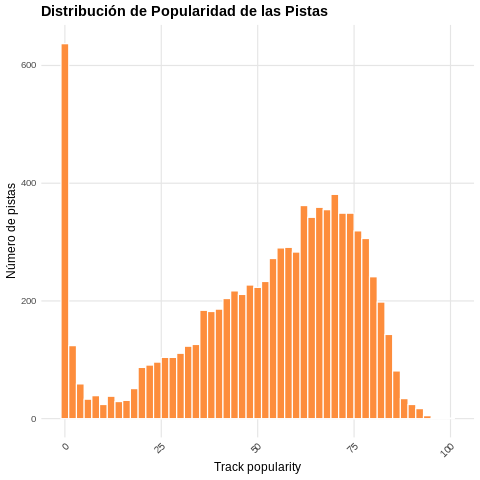

In [146]:
%%R
if ("track_popularity" %in% names(df)) {
  p_pop <- ggplot(
    df %>% filter(!is.na(track_popularity)),
    aes(x = track_popularity)
  ) +
    geom_histogram(
      binwidth = 2,
      color = "white",
      fill = "#FD8D3C"
    ) +
    labs(
      title = "Distribución de Popularidad de las Pistas",
      x = "Track popularity",
      y = "Número de pistas"
    ) +
    theme_spotify

  ggsave(file.path(params$out_dir, "01_popularity_hist.png"),
         p_pop, width = 8, height = 5)
  p_pop
}


# Histograma de Popularidad de Pistas

En esta celda se visualiza la **distribución de la popularidad de las pistas** en el dataset, lo que ayuda a comprender la estructura de los datos y detectar posibles sesgos.

### Pasos realizados:

1. **Verificación de la columna `track_popularity`**:
   - Solo se crea el gráfico si la columna existe en el dataset.

2. **Filtrado de valores nulos**:
   - Se eliminan filas donde `track_popularity` es `NA` para que la visualización sea precisa.

3. **Creación del histograma**:
   - Se usa `ggplot2` para graficar:
     - `x = track_popularity` (popularidad de la pista, de 0 a 100)
     - `geom_histogram()` con `binwidth = 2` para agrupar la popularidad en intervalos de 2 unidades.
     - Colores y estilo visual (`viridis` y `theme_spotify`) para que sea claro y atractivo.

4. **Etiquetas del gráfico**:
   - `title` → "Distribución de Popularidad de las Pistas"
   - `subtitle` → Explica el propósito del histograma y posibles sesgos.
   - `x` → "Track popularity"
   - `y` → "Número de pistas"

5. **Guardado del gráfico**:
   - Se guarda automáticamente en el directorio de salida definido por `params$out_dir` con nombre `"01_popularity_hist.png"` y tamaño 8x5 pulgadas.

6. **Resultado**:
   - Visualización clara de cómo se distribuyen las canciones según popularidad.
   - Permite identificar si hay muchas canciones poco populares o si el dataset está sesgado hacia hits.

### Por qué es importante:

- Conocer la distribución de popularidad ayuda a:
  - Planificar análisis posteriores y modelado.
  - Detectar sesgos o desbalance en los datos.
  - Comprender la composición del dataset antes de crear variables derivadas o categorías como `popularity_label`.



(`geom_bar()`). 



In addition: Warning message:
Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 


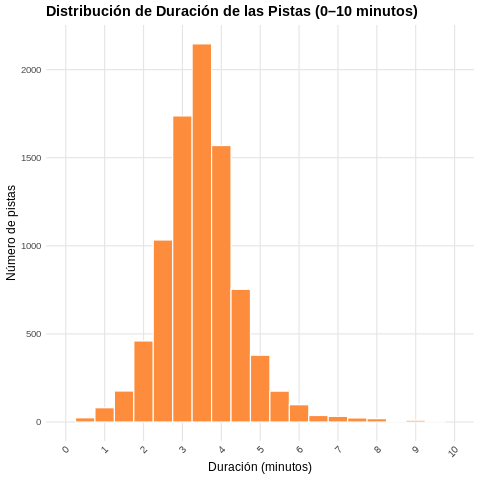

In [147]:
%%R
if ("duration_min" %in% names(df)) {
  p_dur <- df %>%
    filter(!is.na(duration_min)) %>%
    filter(duration_min >= 0, duration_min <= 10) %>%
    ggplot(aes(x = duration_min)) +
    geom_histogram(
      binwidth = 0.5,
      color = "white",
      fill = "#FD8D3C"
    ) +
    scale_x_continuous(limits = c(0, 10), breaks = seq(0, 10, by = 1)) +
    labs(
      title = "Distribución de Duración de las Pistas (0–10 minutos)",
      x = "Duración (minutos)",
      y = "Número de pistas"
    ) +
    theme_spotify

  ggsave(file.path(params$out_dir, "02_duration_hist_0_10.png"),
         p_dur, width = 8, height = 5)
  p_dur
}

# Histograma de Duración de Pistas

En esta celda se visualiza la **distribución de la duración de las pistas en minutos**, lo que ayuda a detectar valores atípicos y comprender la composición del dataset.

### Pasos realizados:

1. **Verificación de la columna `duration_min`**:
   - Solo se crea el gráfico si la columna existe en el dataset.

2. **Filtrado de valores nulos**:
   - Se eliminan filas donde `duration_min` es `NA` para asegurar precisión en la visualización.

3. **Creación del histograma**:
   - Se utiliza `ggplot2`:
     - `x = duration_min` (duración de la pista en minutos)
     - `geom_histogram()` con `binwidth = 0.5` para agrupar la duración en intervalos de medio minuto.
     - Colores y estilo visual (`viridis` y `theme_spotify`) para mayor claridad y estética.

4. **Etiquetas del gráfico**:
   - `title` → "Distribución de Duración de las Pistas (minutos)"
   - `subtitle` → Explica el propósito del histograma y cómo identificar posibles outliers.
   - `x` → "Duración (minutos)"
   - `y` → "Número de pistas"

5. **Guardado del gráfico**:
   - Se guarda automáticamente en el directorio de salida definido por `params$out_dir` con nombre `"02_duration_hist.png"` y tamaño 8x5 pulgadas.

6. **Resultado**:
   - Visualización de la distribución de duración.
   - Permite detectar pistas anormalmente cortas o largas, que podrían considerarse outliers en análisis o modelos centrados en música estándar.

### Por qué es importante:

- Identificar la distribución de duración ayuda a:
  - Detectar outliers que pueden sesgar estadísticas o modelos.
  - Comprender el rango típico de duración de las pistas.
  - Preparar el dataset para normalización y análisis comparativo.



(`geom_col()`). 



In addition: Warning message:
Removed 45 rows containing missing values or values outside the scale range
(`geom_col()`). 


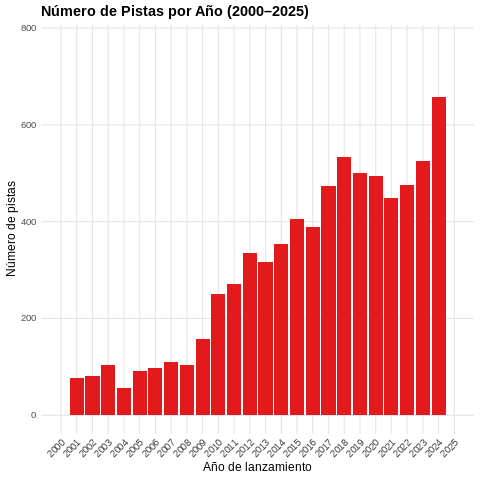

In [148]:
%%R
if ("release_year" %in% names(df)) {
  p_counts <- df %>%
    filter(!is.na(release_year)) %>%
    count(release_year) %>%
    ggplot(aes(x = release_year, y = n)) +
    geom_col(
      fill = "#E31A1C"
    ) +
    scale_x_continuous(
      limits = params$year_limits,
      breaks = seq(params$year_limits[1], params$year_limits[2], by = 1)
    ) +
    labs(
      title = "Número de Pistas por Año (2000–2025)",
      x = "Año de lanzamiento",
      y = "Número de pistas"
    ) +
    theme_spotify

  ggsave(file.path(params$out_dir, "03_tracks_per_year_2000_2025.png"),
         p_counts, width = 12, height = 5)
  p_counts
}


# Número de Pistas por Año

En esta celda se visualiza la **cantidad de pistas lanzadas por año**, lo que permite analizar la representación temporal y la confiabilidad de los datos por año.

### Pasos realizados:

1. **Verificación de la columna `release_year`**:
   - Solo se genera el gráfico si la columna existe en el dataset.

2. **Filtrado de valores nulos**:
   - Se eliminan filas donde `release_year` es `NA` para garantizar que los conteos sean precisos.

3. **Conteo de pistas por año**:
   - Se utiliza `count(release_year)` para calcular el número de pistas lanzadas en cada año.

4. **Creación del gráfico de barras**:
   - `ggplot2` con `geom_col()` para graficar la cantidad de pistas por año.
   - Se usa la paleta `viridis` para colores consistentes y agradables visualmente.
   - `scale_x_continuous()` limita el eje X al rango definido en `params$year_limits` (2000–2025) y establece un salto de 1 año entre marcas.

5. **Etiquetas del gráfico**:
   - `title` → "Número de Pistas por Año (2000–2025)"
   - `subtitle` → Explica la importancia de la representación de cada año y su impacto en el análisis de tendencias.
   - `x` → "Año de lanzamiento"
   - `y` → "Número de pistas"

6. **Guardado del gráfico**:
   - Se guarda automáticamente en `params$out_dir` con nombre `"03_tracks_per_year_2000_2025.png"` y tamaño 12x5 pulgadas.

7. **Resultado**:
   - Permite visualizar qué años están bien representados y cuáles tienen pocos datos, lo que afecta la fiabilidad de análisis históricos o tendencias musicales.

### Por qué es importante:

- Detectar años poco representados ayuda a filtrar o ponderar datos en análisis temporales.
- Facilita la identificación de tendencias de lanzamiento a lo largo del tiempo.
- Es útil para entender la distribución temporal de la muestra antes de análisis de series históricas o modelado.



(`geom_line()`). 

(`geom_point()`). 



In addition: Warning messages:
1: Removed 43 rows containing missing values or values outside the scale range
(`geom_line()`). 
2: Removed 43 rows containing missing values or values outside the scale range
(`geom_point()`). 


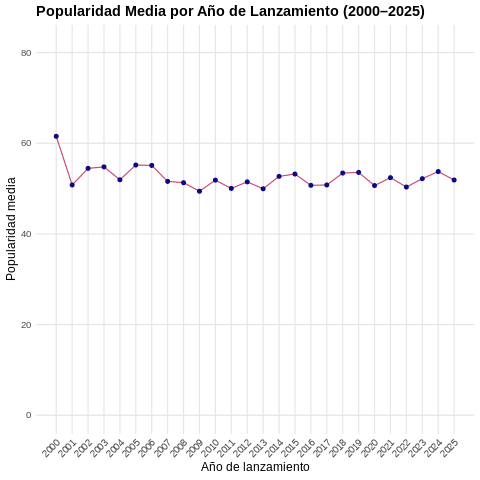

In [149]:
%%R
if (all(c("release_year","track_popularity") %in% names(df)) &&
    any(!is.na(df$release_year))) {


  p_year <- df %>%
    filter(!is.na(release_year)) %>%
    group_by(release_year) %>%
    summarise(
      pop_mean = mean(track_popularity, na.rm = TRUE),
      n = n(),
      .groups = "drop"
    ) %>%
    ggplot(aes(x = release_year, y = pop_mean)) +
    geom_line(color = scales::viridis_pal(option = "C")(3)[2]) +
    geom_point(color = scales::viridis_pal(option = "C")(3)[1]) +
    scale_x_continuous(
      limits = params$year_limits,
      breaks = seq(params$year_limits[1],
                   params$year_limits[2], by = 1)
    ) +
    labs(
      title = "Popularidad Media por Año de Lanzamiento (2000–2025)",
      x = "Año de lanzamiento",
      y = "Popularidad media"
    ) +
    theme_spotify


  ggsave(file.path(params$out_dir,
                   "04_popularity_by_year_2000_2025.png"),
         p_year, width = 12, height = 5)
  p_year
}

# Popularidad Media por Año de Lanzamiento

En esta celda se visualiza cómo **cambia la popularidad promedio de las pistas según el año de lanzamiento**, lo que ayuda a detectar tendencias temporales o drift en el dataset.

### Pasos realizados:

1. **Verificación de columnas necesarias**:
   - Solo se genera el gráfico si existen `release_year` y `track_popularity` y hay al menos un año no nulo.

2. **Filtrado de valores nulos**:
   - Se eliminan filas donde `release_year` es `NA` para asegurar cálculos precisos.

3. **Cálculo de popularidad media por año**:
   - Se agrupa por `release_year` y se calcula:
     - `pop_mean`: promedio de `track_popularity` para ese año.
     - `n`: número de pistas por año (opcional para referencia).
   - `.groups = "drop"` asegura que el resultado no conserve agrupamientos.

4. **Creación del gráfico de línea**:
   - `geom_line()` muestra la tendencia de popularidad media a lo largo de los años.
   - `geom_point()` marca los valores de cada año.
   - Colores `viridis` para consistencia visual.
   - `scale_x_continuous()` limita el eje X al rango definido en `params$year_limits` (2000–2025) y establece marcas cada año.

5. **Etiquetas del gráfico**:
   - `title` → "Popularidad Media por Año de Lanzamiento (2000–2025)"
   - `subtitle` → Explica el propósito: detectar drift temporal o diferencias sistemáticas en popularidad.
   - `x` → "Año de lanzamiento"
   - `y` → "Popularidad media"

6. **Guardado del gráfico**:
   - Se guarda automáticamente en `params$out_dir` con nombre `"04_popularity_by_year_2000_2025.png"` y tamaño 12x5 pulgadas.

7. **Resultado**:
   - Permite observar si las canciones recientes son sistemáticamente más populares que las antiguas.
   - Útil para análisis de tendencias temporales y para identificar sesgos de sampling o drift de datos.

### Por qué es importante:

- Detectar drift temporal ayuda a ajustar modelos predictivos o análisis comparativos.
- Comprender la evolución de popularidad por año facilita interpretación de tendencias históricas.
- Identifica posibles sesgos en el dataset relacionados con el año de lanzamiento.


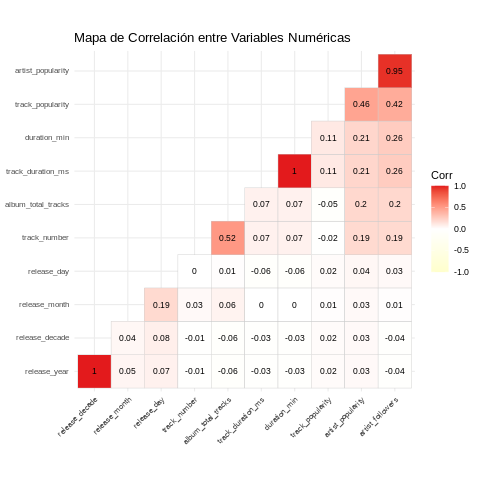

In [150]:
%%R
num_cols_all <- df_corr %>% select(where(is.numeric)) %>% names()

if (length(num_cols_all) >= 2) {

  if (length(num_cols_all) > params$max_vars_for_corr) {
    var_dt <- df_corr %>%
      select(all_of(num_cols_all)) %>%
      summarise(across(everything(), ~ var(.x, na.rm = TRUE))) %>%
      pivot_longer(everything(), names_to = "var", values_to = "v") %>%
      arrange(desc(v))
    num_cols <- var_dt$var[1:params$max_vars_for_corr]
  } else {
    num_cols <- num_cols_all
  }

  cor_mat <- df_corr %>%
    select(all_of(num_cols)) %>%
    mutate(across(everything(), as.numeric)) %>%
    cor(use = "pairwise.complete.obs")

  p_corr <- ggcorrplot(
    cor_mat,
    method = "square",
    type = "lower",
    lab = TRUE,
    lab_size = 3,
    tl.cex = 8,
    tl.srt = 45,
    hc.order = TRUE,
    outline.color = "grey80",
    colors = c("#FFFFCC", "white", "#E31A1C")
  ) +
    ggtitle("Mapa de Correlación entre Variables Numéricas")

  ggsave(file.path(params$out_dir, "05_correlation_heatmap.png"),
         p_corr, width = 10, height = 10, dpi = 300)
  p_corr
}

# Mapa de Correlación de Variables Numéricas

En esta celda se calcula y visualiza la **correlación entre variables numéricas** del dataset, lo que permite identificar relaciones lineales, redundancias y posibles problemas de multicolinealidad.

### Pasos realizados:

1. **Selección de columnas numéricas**:
   - `num_cols_all` obtiene todas las columnas del dataset que son numéricas.
   - Se procede solo si hay al menos 2 columnas numéricas.

2. **Filtrado de variables según varianza**:
   - Si hay más columnas de las permitidas (`params$max_vars_for_corr`), se seleccionan las que tienen mayor varianza.
   - Esto evita mapas de correlación demasiado grandes y centrados en las variables más informativas.
   - `var()` calcula la varianza de cada columna y se ordena de mayor a menor.

3. **Cálculo de la matriz de correlación**:
   - Se seleccionan las columnas finales (`num_cols`) y se convierten a numéricas.
   - `cor()` calcula la correlación usando `pairwise.complete.obs` para ignorar valores faltantes.

4. **Creación del mapa de calor de correlación**:
   - Se usa `ggcorrplot()`:
     - `method = "square"` → cuadros para representar correlaciones.
     - `type = "lower"` → solo la mitad inferior de la matriz.
     - `lab = TRUE` → muestra valores de correlación.
     - `hc.order = TRUE` → orden jerárquico de variables para agrupar correlaciones similares.
     - Paleta de colores `viridis` para resaltar correlaciones negativas y positivas.

5. **Etiquetas y título**:
   - `ggtitle()` → "Mapa de Correlación entre Variables Numéricas"

6. **Guardado del gráfico**:
   - Se guarda automáticamente en `params$out_dir` como `"05_correlation_heatmap.png"`, tamaño 10x10 pulgadas y 300 dpi.

7. **Resultado**:
   - Visualización clara de la fuerza y dirección de las correlaciones entre variables numéricas.
   - Permite detectar redundancias y variables que podrían influir en modelado o análisis estadístico.

### Por qué es importante:

- Ayuda a identificar **multicolinealidad**, útil para regresión y modelos predictivos.
- Facilita la selección de variables relevantes evitando redundancia.
- Permite entender relaciones entre características numéricas antes de modelar o analizar patrones.


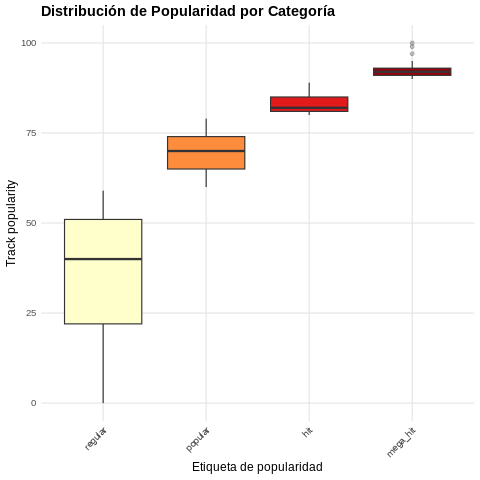

In [151]:
%%R
if (all(c("popularity_label","track_popularity") %in% names(df))) {
  p_box <- df %>%
    ggplot(aes(x = popularity_label, y = track_popularity, fill = popularity_label)) +
    geom_boxplot(outlier.alpha = 0.3) +
    scale_fill_manual(
      values = c("regular" = "#FFFFCC",
                 "popular" = "#FD8D3C",
                 "hit" = "#E31A1C",
                 "mega_hit" = "#99000D")
    ) +
    labs(
      title = "Distribución de Popularidad por Categoría",
      x = "Etiqueta de popularidad",
      y = "Track popularity"
    ) +
    theme_spotify +
    theme(legend.position = "none")

  ggsave(file.path(params$out_dir, "07_popularity_by_label_boxplot.png"),
         p_box, width = 7, height = 5)
  p_box
}

# Distribución de Popularidad por Categoría

En esta celda se visualiza cómo se distribuye la popularidad de las pistas según la **etiqueta categórica `popularity_label`**, permitiendo comprobar que las categorías reflejan diferencias reales en popularidad.

### Pasos realizados:

1. **Verificación de columnas necesarias**:
   - Solo se genera el gráfico si existen `popularity_label` y `track_popularity`.

2. **Creación del boxplot**:
   - `ggplot2` con:
     - `x = popularity_label` → categoría de popularidad (`regular`, `popular`, `hit`, `mega_hit`)
     - `y = track_popularity` → popularidad numérica de la pista
     - `fill = popularity_label` → colores según categoría
   - `geom_boxplot(outlier.alpha = 0.3)`:
     - Muestra la mediana, cuartiles y posibles outliers.
     - Outliers se hacen semitransparentes para no saturar el gráfico.
   - Se aplica paleta de colores y tema personalizado `theme_spotify`.
   - `theme(legend.position = "none")` oculta la leyenda, ya que el color ya corresponde al eje X.

3. **Etiquetas del gráfico**:
   - `title` → "Distribución de Popularidad por Categoría"
   - `subtitle` → Explica el propósito: verificar que los bins categóricos separan niveles distintos.
   - `x` → "Etiqueta de popularidad"
   - `y` → "Track popularity"

4. **Guardado del gráfico**:
   - Se guarda automáticamente en `params$out_dir` como `"07_popularity_by_label_boxplot.png"`, tamaño 7x5 pulgadas.

5. **Resultado**:
   - Permite visualizar la **dispersión de popularidad dentro de cada categoría**.
   - Verifica que las etiquetas (`regular`, `popular`, `hit`, `mega_hit`) reflejan diferencias significativas en la popularidad.

### Por qué es importante:

- Ayuda a **validar la creación de categorías** a partir de una variable continua.
- Facilita la detección de posibles solapamientos o outliers dentro de cada bin.
- Útil para análisis descriptivo y para comunicar de forma clara cómo se segmentan los niveles de popularidad.
